<p> Connecting SQL Database to program </p>

In [1]:
import mysql.connector as sql

conn = sql.connect(
    host='127.0.0.1',
    user='root',
    password='password',
    database='used_car_db',
    use_pure=True
)


<p> Storing it into a Dataframe </p>

In [2]:
import pandas as pd

cursor=conn.cursor()

query = "select * from new_table"
cursor.execute(query)

#Get data and column names
rows = cursor.fetchall()
columns = cursor.column_names

df = pd.DataFrame(rows, columns=columns)

print(df)

conn.close()

      make_year mileage_kmpl  engine_cc fuel_type  owner_count price_usd  \
0          2001         8.17       4000    Petrol            4   8587.64   
1          2014        17.59       1500    Petrol            4    5943.5   
2          2023        18.09       2500    Diesel            5   9273.58   
3          2009        11.28        800    Petrol            1   6836.24   
4          2005        12.23       1000    Petrol            2   4625.79   
...         ...          ...        ...       ...          ...       ...   
9995       1996        15.25       1500    Petrol            2   5498.71   
9996       1997        14.45       5000    Diesel            1   9588.31   
9997       2002        19.41       1000    Diesel            4    4557.1   
9998       2005        12.95       4000    Petrol            5   7413.59   
9999       2007        18.81       5000    Petrol            1  11634.09   

          brand transmission   color service_history  accident_reports  \
0     Chevrol

In [3]:
Check for missing and duplicated data

SyntaxError: invalid syntax (1709506437.py, line 1)

In [4]:
df_clean = df.copy()

#Check for missing values
print("Missing values per column: ")
print(df_clean.isnull().sum())

#Check for duplicate rows
duplicates = df_clean.duplicated().sum()
print(f"\nDuplicated rows: {duplicates}")

#If duplicate rows exist, drop them
if duplicates > 0:
    df_clean.drop_duplicates(inplace=True)

Missing values per column: 
make_year           0
mileage_kmpl        0
engine_cc           0
fuel_type           0
owner_count         0
price_usd           0
brand               0
transmission        0
color               0
service_history     0
accident_reports    0
insurance           0
dtype: int64

Duplicated rows: 0


In [5]:
Feature Engineering

SyntaxError: invalid syntax (2107749883.py, line 1)

In [6]:
from datetime import datetime
#Overall age of car is a more useful feature than make year
df_clean['car_age'] = datetime.now().year - df_clean['make_year']
df_clean.drop(columns=['make_year'], inplace=True) #Dropping to avoid redundancy

In [7]:
Encode categorical data (One-hot and ordinal)

SyntaxError: invalid syntax (2625403156.py, line 1)

In [8]:
#One hot encoding: Converting categorical variables into binary columns
df_clean = pd.get_dummies(
    df_clean,
    columns=['fuel_type', 'brand', 'transmission', 'color', 'insurance'],
    drop_first=True
)

#Ordinal encoding: Converting service_history into ordered values
service_mapping = {'None': 0, 'Partial': 1, 'Full': 2}
df_clean['service_history'] = df_clean['service_history'].map(service_mapping)

In [ ]:
Normalize numeric features

In [85]:
from sklearn.preprocessing import StandardScaler

#Converting numeric-like strings into numeric values
df_clean['mileage_kmpl'] = pd.to_numeric(df_clean['mileage_kmpl'], errors='coerce')
df_clean['price_usd'] = pd.to_numeric(df_clean['price_usd'], errors='coerce')

#Choosing numeric columns to scale, excluding price_usd
numeric_cols = ['mileage_kmpl', 'engine_cc', 'owner_count', 'accident_reports', 'car_age']

df_plot = df_clean.copy()

#Applying standard scaling, which means all numeric features listed above have mean of 0 and std of 1
#This practice helps with the models we'll most likely be using
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

print("\nNumeric features normalized")



Numeric features normalized


In [ ]:
Feature selection to identify most useful features

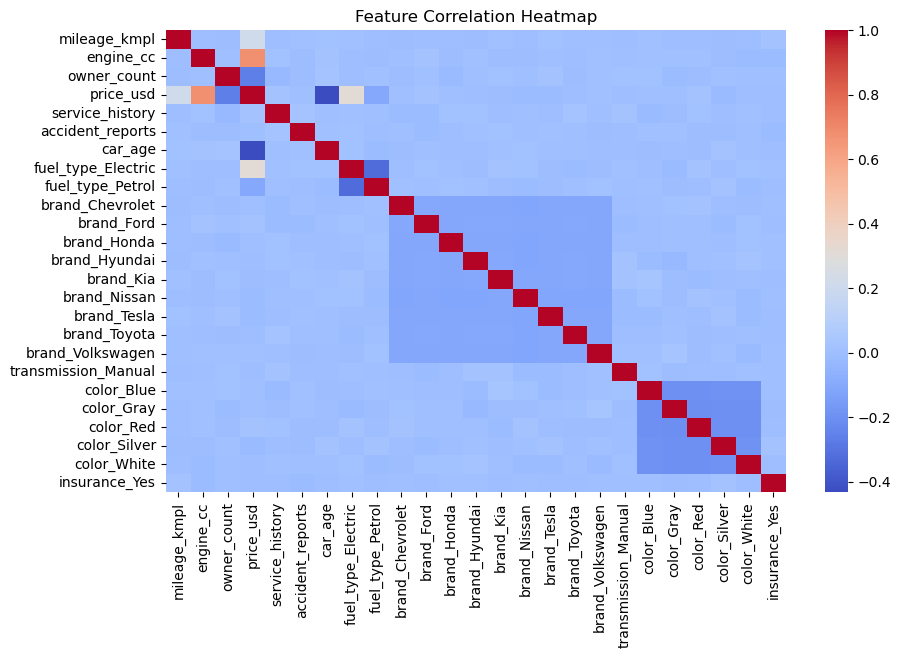


Top features correlated with price_usd:
price_usd             1.000000
engine_cc             0.678161
fuel_type_Electric    0.312584
mileage_kmpl          0.211971
color_Red             0.017251
brand_Ford            0.016184
service_history       0.015590
brand_Volkswagen      0.007371
brand_Honda           0.003299
color_Blue            0.002856
Name: price_usd, dtype: float64


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

#Calculate correlations to see which features relate most to our target, price_usd
corr = df_clean.corr()

#Visualizing these relationships with a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#Print the top features
print("\nTop features correlated with price_usd:")
print(corr['price_usd'].sort_values(ascending=False).head(10))

In [ ]:
Check for outliers

In [35]:
#Using the IQR method to detect outliers, and values outside the 1.5 * IQR range
Q1 = df_clean['price_usd'].quantile(0.25)
Q3 = df_clean['price_usd'].quantile(0.75)

IQR = Q3 - Q1

outliers = df_clean[(df_clean['price_usd'] < Q1 - 1.5*IQR) | (df_clean['price_usd'] > Q3 + 1.5*IQR)]
print(f"\nOutliers in price_usd: {len(outliers)}")

#Save copy of dataset before removing outliers (just in case)
df_before_outliers = df_clean.copy()

#Removing outliers
df_clean = df_clean[(df_clean['price_usd'] >= Q1 - 1.5*IQR) & 
           (df_clean['price_usd'] <= Q3 + 1.5*IQR)]
print("\nOutliers removed")

print(f"Final dataset shape: {df_clean.shape}")


Outliers in price_usd: 58

Outliers removed
Final dataset shape: (9942, 25)


In [ ]:
Save new cleaned data set

In [36]:
df_clean.to_csv('clean_used_car_data.csv', index=False)
print("\nCleaned data set saved to clean_used_car_data.csv")


Cleaned data set saved to clean_used_car_data.csv


In [ ]:
Exploring the data: histogram of car prices

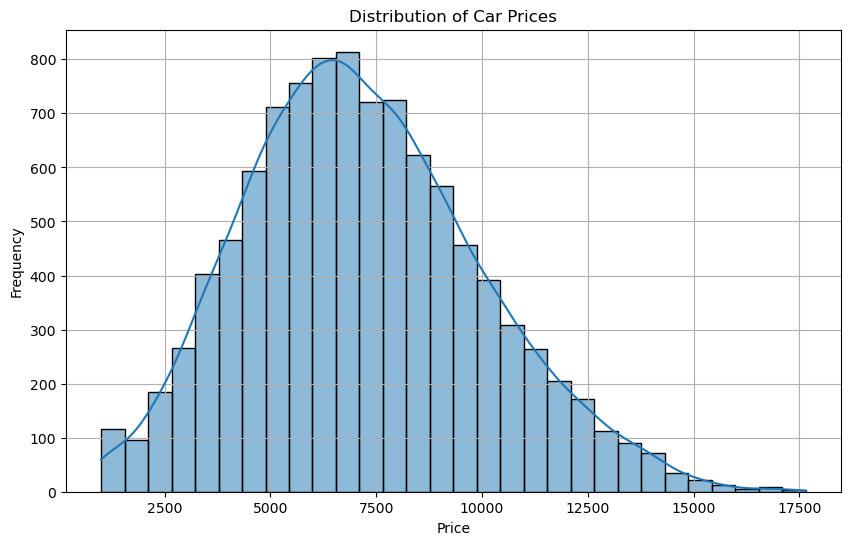

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(df_plot['price_usd'], bins=30, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [66]:
 Slightly right skewed, showing most cars are listed between $5,000 to $8,000 and a few listed higher.

SyntaxError: invalid syntax (4117865908.py, line 1)

In [15]:
Mileage vs Price

SyntaxError: invalid syntax (1700373216.py, line 1)

In [73]:
#combining electric/patrol to one column
def detect_fuel_type(row):
    if row['fuel_type_Petrol']:
        return 'Petrol'
    elif row['fuel_type_Electric']:
        return 'Electric'
    else:
        return 'Other'  # in case both are false

df_plot['fuel_type'] = df_plot.apply(detect_fuel_type, axis=1)

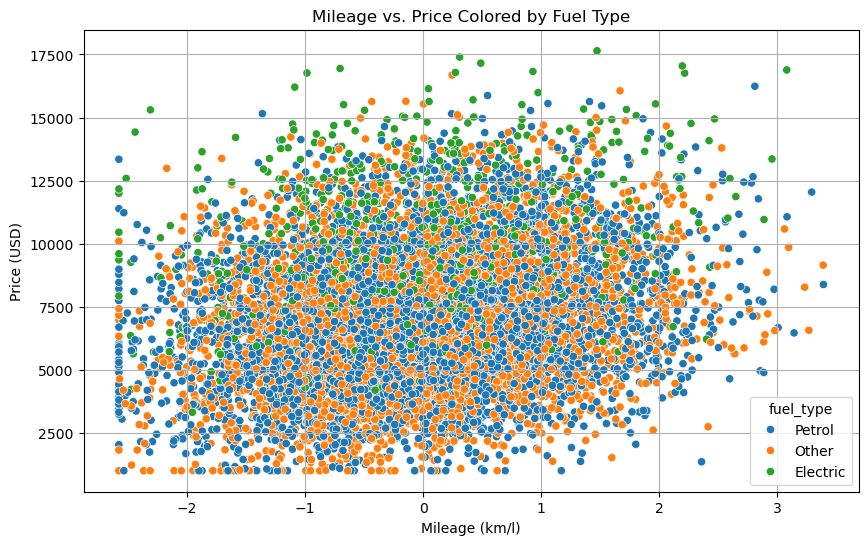

In [87]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='mileage_kmpl', y='price_usd', hue='fuel_type')
plt.title("Mileage vs. Price Colored by Fuel Type")
plt.xlabel("Mileage (km/l)")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

In [88]:
This scatter plot shows electric vehicles are slightly more expensive than petrol, but it does not show a strong relationship between mielage and price.

SyntaxError: invalid syntax (4102829739.py, line 1)

In [ ]:
Engine Size vs Price

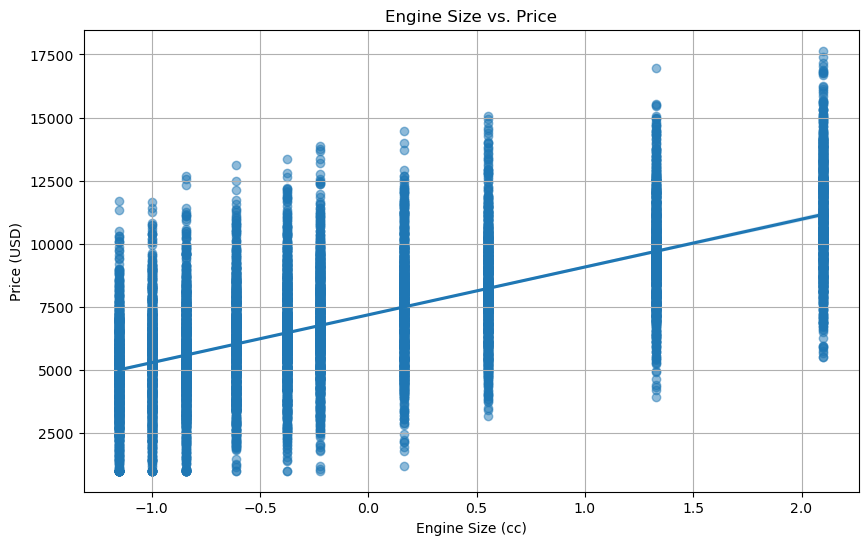

In [89]:
plt.figure(figsize=(10,6))
sns.regplot(data=df_plot, x='engine_cc', y='price_usd', scatter_kws={'alpha':0.5})
plt.title("Engine Size vs. Price")
plt.xlabel("Engine Size (cc)")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

In [49]:
This chart shows a positive linear relationship between engine size and the price. It does show a increase in price for larger engine sizes.

SyntaxError: invalid syntax (4031219474.py, line 1)